In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from urllib.request import urlopen

# 1. Active Weekly Users

**Bounty:** Show the number of active users (wallets) per week on Uniswap and SushiSwap over the past year. How do these two charts compare? Why might this be?

**Conculsion**:  Both DEXs have seen growth so far this year. There is a significant bump in addresses on Uniswap in May, which is most likely due to the launch of Uniswap V3. This is in contrast to SushiSwap which shows a steady increase in addresses.



## Pull the data

We're going to query the `ethereum.dex_swaps` table find the weekly number of distinct wallets that are interacting with the two platforms

In [2]:
query = '''
  SELECT
  'sushiswap' AS platform,
  WEEK(BLOCK_TIMESTAMP) AS weekNumber,
  MIN(DATE(BLOCK_TIMESTAMP)) AS minDate,
  MAX(DATE(BLOCK_TIMESTAMP)) AS maxDate,
  COUNT(DISTINCT to_address) AS addressCount
  FROM ethereum.dex_swaps
  WHERE PLATFORM = 'sushiswap' --uniswap-v2 uniswap-v3
  AND DATE(BLOCK_TIMESTAMP) >= '2021-01-01'
  GROUP BY WEEK(BLOCK_TIMESTAMP)
UNION ALL
  SELECT
  'uniswap' AS platform,
  WEEK(BLOCK_TIMESTAMP) AS weekNumber,
  MIN(DATE(BLOCK_TIMESTAMP)) AS minDate,
  MAX(DATE(BLOCK_TIMESTAMP)) AS maxDate,
  COUNT(DISTINCT to_address) AS addressCount
  FROM ethereum.dex_swaps
  WHERE PLATFORM in ('uniswap-v2', 'uniswap-v3')
  AND DATE(BLOCK_TIMESTAMP) >= '2021-01-01'
  GROUP BY WEEK(BLOCK_TIMESTAMP)

'''

In [3]:
# Pull query data from API 

url = 'https://api.flipsidecrypto.com/api/v2/queries/0d0b4417-93a4-46e4-b7ad-b72d3443877f/data/latest'

response = urlopen(url)
data_json = json.loads(response.read())
df = pd.DataFrame(data_json)

In [4]:
# Clean the df
df.sort_values('WEEKNUMBER', inplace=True)
df['MINDATE'] = pd.to_datetime(df['MINDATE'])
df['MAXDATE'] = pd.to_datetime(df['MAXDATE'])

df['days'] = df['MAXDATE'] - df['MINDATE']
df['days'] = df['days'].dt.days + 1
df['ADDRESSCOUNT_norm'] = df['ADDRESSCOUNT'] / df['days'] * 7

df['week_label'] = df['MINDATE'].dt.strftime('%m/%d/%Y') + '-'+ df['MAXDATE'].dt.strftime('%m/%d/%Y')

df_sushi = df[df['PLATFORM'] == 'sushiswap']
df_uni = df[df['PLATFORM'] == 'uniswap']

## Plot the Data

C:\Users\Billy\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


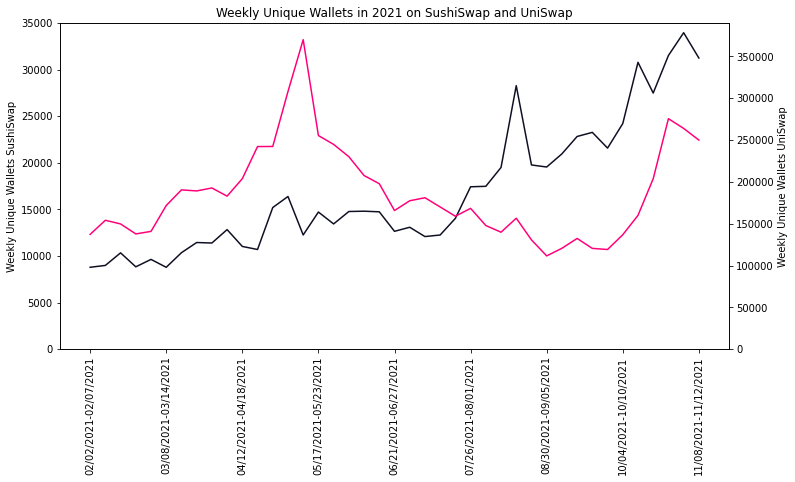

In [5]:
# Plot counts over time for both uni and sushi

fig, ax1 = plt.subplots(figsize=(12,6))

ax2 = ax1.twinx()
ax1.plot(df_sushi['WEEKNUMBER'], df_sushi['ADDRESSCOUNT_norm'], color='#0e0f23')
ax2.plot(df_uni['WEEKNUMBER'], df_uni['ADDRESSCOUNT_norm'], color='#ff007a')

ax1.set_ylim(0,35000)
ax2.set_ylim(0,390000)

ax1.tick_params(axis="x", labelbottom=True, rotation=90)

ax1.set_ylabel('Weekly Unique Wallets SushiSwap')
ax2.set_ylabel('Weekly Unique Wallets UniSwap')
plt.title('Weekly Unique Wallets in 2021 on SushiSwap and UniSwap')

plt.draw()

labels = [item.get_text() for item in ax1.get_xticklabels()]
date_labels = [df_uni[df_uni['WEEKNUMBER'] == int(x)]['week_label'].values[0] for x in labels[1:10]]
date_labels = list(labels[0]) + date_labels + list(labels[10])
ax1.set_xticklabels(date_labels)

plt.show()

The chart above shows the number of unique wallets on Uniswap and SushiSwap from the 02/02/21 (earliest data on `ethereum.dex_swaps` for both) until 11/12/21. The raw number of wallets on SushiSwap are plotted on the left-hand y-axis and the raw number of wallets on Uniswap are plotted on the right-hand y-axis. Note that the Uniswap values are 10x the SushiSwap numbers.  